# PHY3009 Tutorial Week 11: Model testing & MCMC fitting #

The first part of this week’s tutorial focuses on model-testing and the MCMC method.

**Exercise 1:** Using the χ^2 fits from the Week 10 tutorial, calculate the BIC & AIC and determine the best fit model to the data from the Week 10 tutorial. You can do that in the workbook for that week.


### MCMC fitting
The aim of this tutorial is to write a MCMC method based on the Metropolis-Hastings Algorithm, and then apply it to the data used in the tutorial of week 10 for the three models listed there ($d=\frac{cz}{H_0}(1+\frac{z}{2})$, $d=\frac{2c}{H_0}(1+z-\sqrt{1+z})$, and d from FlatLambdaCDM())

In [1]:
# importing some basic python packages
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as ascii # to help with reading in data
from astropy.cosmology import FlatLambdaCDM   #import for determining the model for a universe 
                                              #containing both (dark) matter and dark energy

%matplotlib inline



To make your MCMC code more generic (so you can use it for many different problems), you should provide the initial parameters as an array and take advantage of the fact that in Python you can pass a function to another function (you can even get a function to return a function, which can be useful in certain cases, although we won’t need that here). 
Here is a sample code to show how you can pass a function to another function. In this example, your MCMC function would take the place of the _example_passing_function()_ function.


In [2]:
def example_passing_function(model_func,x,pars):
    model=model_func(x,pars)
    return model
    
def myfunct1(x,pars):
    return x*pars[0]+pars[1]

def myfunct2(x,pars):
    return x**2*pars[0]+pars[1]
    
    
x=np.arange(10)
print(example_passing_function(myfunct1,x,(5.,2.)))
print(example_passing_function(myfunct2,x,(5.,2.)))

[ 2.  7. 12. 17. 22. 27. 32. 37. 42. 47.]
[  2.   7.  22.  47.  82. 127. 182. 247. 322. 407.]


**Exercise 2:** Annotate the simple MCMC routine that can be found on Canvas. 


The MCMC should perform the following steps:

1. Calculate the model for the initial parameters

2. Calculate the $\chi^2$ for the initial parameters, call this $\chi_0^2$

3. Make an array to store the MCMC in, this should be a 2d-array with one axis for the different parameters and the other axis the steps of the chain. For instance, for 2 parameters and 100,000 steps you should make a [2,100000] or a [100000,2] array. Make sure that you the function can accept different number of parameters/steps (i.e. don’t hard-code the numbers)

4. For each parameter, draw a random number from a normal distribution with a mean of the current value of the parameters and a sigma equal to the stepsize.

5. Calculate the model for the new parameter

6. Calculate the $\chi^2$ for the new parameter.

7. Calculate $\Delta\chi^2\equiv\chi^2-\chi^2_0$

8. If $\Delta\chi^2\leq0$: accept the jump. If $\Delta\chi^2>0$ you need to 

    a. Draw a uniform random number between 0 and 1    
    b. If this random number is smaller than $e^{-\Delta\chi^2/2}$ accept the jump, else reject it.
   
9. If the jump is accepted: Store the trial parameter values in the chain and set $\chi_0^2\chi^2$; If the jump is rejected: store the position at the start of this step (i.e. not your trial position) in the chain and keep the original $\chi_0^2$.

10. Repeat step 4 – 9 for the desired number of steps



In [3]:
import numpy as np

'''
mcmc:  function to perform a simple MCMC using the Metropolis-Hastings Algorithm

Inputs:
func  - the function to be used for fitting. Function should accept 2 inputs
        the first is the x-values at which the model is calculated, the second
        is a numpy array for the parameters.
x     - the x-values at which the model should be calculated (numpy array)
y     - the value of the data for each x (numpy array)
sig   - the uncertainty on y (numpy array)
pars0 - The initial parameters from which to start the MCMC chain (numpy array)
stepsize - the stepsize for each of the parameters (numpy array)
nstep    - the number of steps in the MCMC chain

Outputs:
chain    - The MCMC chain as a (Nsteps, Npars) numpy array
'''
def mcmc(func,x,y,sig,pars0,stepsize,nstep=1e2):
    nstep=int(nstep)     #ensures that both axis are integers
    npars=pars0.shape[0] #size of one axis based on number of initial parameters
    chain=np.zeros((int(nstep),npars)) # 2d array 
    chi2=np.zeros(int(nstep))

    chain[0,:]=pars0.copy() #inserts the initial parametersto the begining of chain 
    mdl=func(x,*pars0)   #model for chi squared
    chi2[0]=np.sum( (y-mdl)**2/sig**2) # chi0^2 equation for the initial parameters
    njump=0               #counter for if jump occurs
    for i in range(1,nstep):
        pars_new=np.random.normal(chain[i-1,:],stepsize)
        mdl=func(x,*pars_new)
        chi2_new=np.sum( (y-mdl)**2/sig**2)  #chi2 at new location
        if (chi2_new > chi2[i-1]):  #if new chi2 is bigger than old continue
            p0=np.exp(-(chi2_new-chi2[i-1])/2.) # probability of jumping to new location
            p=np.random.uniform(0,1,1)  #random number between 1 and zero
            if  p<=p0:  #if p<=p0 all variables are locked in and the jump counter increments
                chain[i,:]=pars_new
                chi2[i]=chi2_new
                njump=njump+1
            else:    # else variables remain constant
                chain[i,:]=chain[i-1,:]
                chi2[i]=chi2[i-1]
        else: # if the new chi2 is smaller than old, all variables are locked in and the jump counter increments
            chain[i,:]=pars_new
            njump=njump+1
            chi2[i]=chi2_new
    print('Jump fraction: %.3f' %(njump/nstep))
    return chain

Apply your MCMC routine to the data from last week for each of the three models and determine the uncertainties from the parameters. Run the MCMC routine for at least 100,000 steps, and 5 times per model. Determine the best fit parameters and the uncertainties by combining the 5 chains.

In [4]:
def model_mass(z,H0):
    d=((2*299792)/H0)*(1+z-(np.sqrt(1+z)))
    return d

def model_massless(z,H0):
    d=((299792*z)/H0)*(1+(z/2))
    return d

data = ascii.read('SNIafull.dat')
z=data['z']
idx=np.argsort(z)
M=data['mag']
d=(10**(((M+19)/5)+1))/(1000000)  #MPc
exponetal_uncert=np.sqrt((data['e_mag']**2)+(0.4**2))/5
derr=((10**(((M+19)/5)+1))/(1000000))*np.log(10)*exponetal_uncert 
z=z[idx]
d=d[idx]
derr=derr[idx]
print("")

Jump fraction: 0.846
H0: 74.30367654777181


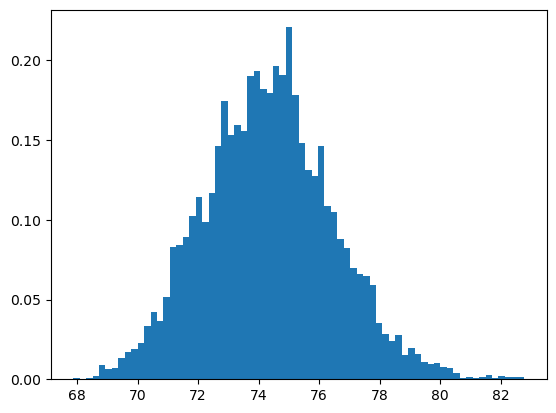

In [5]:
masslesspara=np.array([80])    #hubbles constant inital value 
masslessstepsize=np.array([1])

new_parameter=mcmc(model_massless,z,d,derr,masslesspara,masslessstepsize,nstep=1e4)
a=int(new_parameter.shape[0]) #to burn the first 10% of values
b=a*0.1


plt.hist(new_parameter[int(b):],bins=70,density=True,stacked=True)
print("H0:",np.mean(new_parameter))

In [6]:
massdompara=np.array([67])    #hubbles constant inital value 
massdomstepsize=np.array([.1])

new_parameter=mcmc(model_mass,z,d,derr,massdompara,massdomstepsize,nstep=1e5)

plt.hist(new_parameter,bins=70,density=True,stacked=True)
print("H0:",np.mean(new_parameter))

ValueError: operands could not be broadcast together with shapes (2,) (60,) 

In [4]:
chain=[0,4,6,3,3,5]

s=np.random.normal(chain,[1,3,5,3,2,1])
print(s)

[-0.93023582 11.0405186   9.20813398  6.83619196  4.89150796  5.03722711]
